# **Anomaly Detection in Network Traffic with K-means clustering**
We can categorize machine learning algorithms into two main groups: supervised learning and unsupervised learning. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called clusters. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful tutorial.

# Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

# Steps
1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# **1. K-means**
# **1.1. Introduction**
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of  k , it tries to build  k  clusters from samples in the dataset. Therefore,  k  is an hyperparameter of the model. The right value of  k  is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a  d -dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a  d -dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

# **1.2. How does it work ?**
Given  k , the K-means algorithm works as follows:

1. Randomly choose  k  data points (seeds) to be the initial centroids
2. Assign each data point to the closest centroid
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result. From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

# **1.3. Illustrative example**
One of the best ways to study an algorithm is trying implement it. In this section, we will go step by step to implement a simple K-means algorithm.

Use the below function to calculate an euclidean distance between any two points in  d -dimensional data space.

In [12]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([(c1 - c2)**2 for c1, c2 in zip(p1, p2)]))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

Given a data point and the current set of centroids, use the function below to find the index of the closest centroid for that data point.

In [13]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    return min(enumerate(centroids), key=lambda x: euclidean_distance(datapoint, x[1]))[0]

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

Use the function below to randomize  k  initial centroids.

In [14]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    random_indices = np.arange(len(data))
    np.random.shuffle(random_indices)
    random_indices = random_indices[:k]
    centroids = [data[i] for i in range(len(data)) if i in random_indices]
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

Use function check_converge to check the stop creteria of the algorithm.

In [15]:
MAX_ITERATIONS = 10

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    distances = np.array([euclidean_distance(c, o) for c, o in zip(centroids, old_centroids)])
    if (distances <= threshold).all():
        return True
    return False

Use function update_centroid to update the new positions for the current centroids based on the position of their members.

In [16]:
# centroids: a list of centers
# clusters: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, clusters):
    assert(len(centroids) == len(clusters))
    clusters = np.array(clusters)
    for i, cluster in enumerate(clusters):
        centroids[i] = sum(cluster)/len(cluster)
    return centroids

Use the K-means algorithm scheleton below, with the functions you wrote above.

In [17]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    data = np.array(data)
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

<ipython-input-16-cb27b820ad2b>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clusters = np.array(clusters)


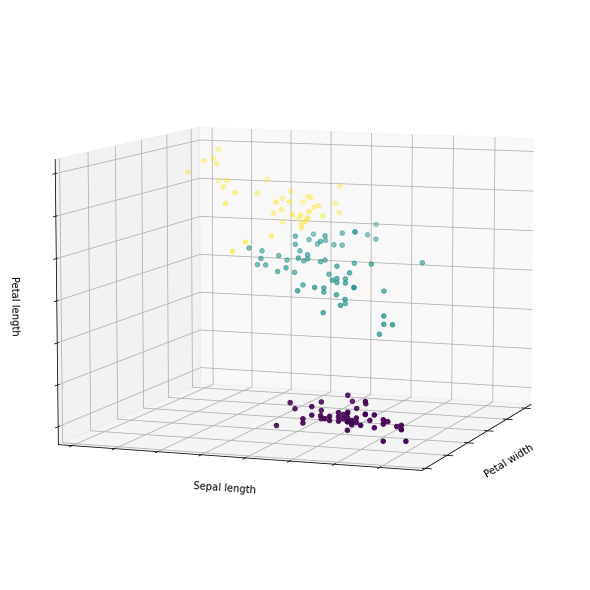

In [18]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
# np.random.seed(0)
# X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

# centers = kmeans(X, k=3)
# labels = [find_closest_centroid(p, centers) for p in X]

# fig = plt.figure(1, figsize=(8, 8))
# plt.clf()
# plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_

# **2. Usecase: Network Intrusion**
Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.

# **2.1. Data**
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as su_attempted in the 15th column. Some features are counts, like num_file_creations in the 17th columns. Some others are the number of sent and received bytes.

# **2.2. Clustering without using categorical features**
First, we need to import some packages that are used in this notebook.

In [19]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [20]:
import os
import sys
import re
import time
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
# from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from operator import add
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import itertools
from pyspark import SparkContext

sc = spark.sparkContext

input_path = "kddcup.data"
raw_data = sc.textFile(input_path, 12)


# **2.2.1. Loading data**
There are two types of features: numerical features and categorical features. Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1:** we don't use the labels in the training phase !!!

**Note 2:** in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

# **Question 1**
Write function parseLine to construct a tuple of (label, vector) for each connection, extract the data that contains only the data points (without label), then print the number of connections.

Where,

* label is the pre-defined label of each connection
* vector is a numpy array that contains values of all features, but the label and the categorial features at index 1,2,3 of each connection. Each vector is a data point.

In [21]:
def parseLine(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [x for i, x in enumerate(vector) if i not in [1, 2, 3]]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine).cache()

# we only need the data, not the label
data = labelsAndData.map(lambda x : x[1]).cache()

# number of connections
n = data.count()

In [22]:
print("Number of connections:", n)
print("Details per connection:", len(data.first()))

Number of connections: 4898431
Details per connection: 38


In [23]:
x = labelsAndData.map(lambda x: x[0]).distinct().count()
print("Total number of labels:\n", x)
y = labelsAndData.map(lambda x : (x[0], 1)).reduceByKey(add).collect()

Total number of labels:
 23


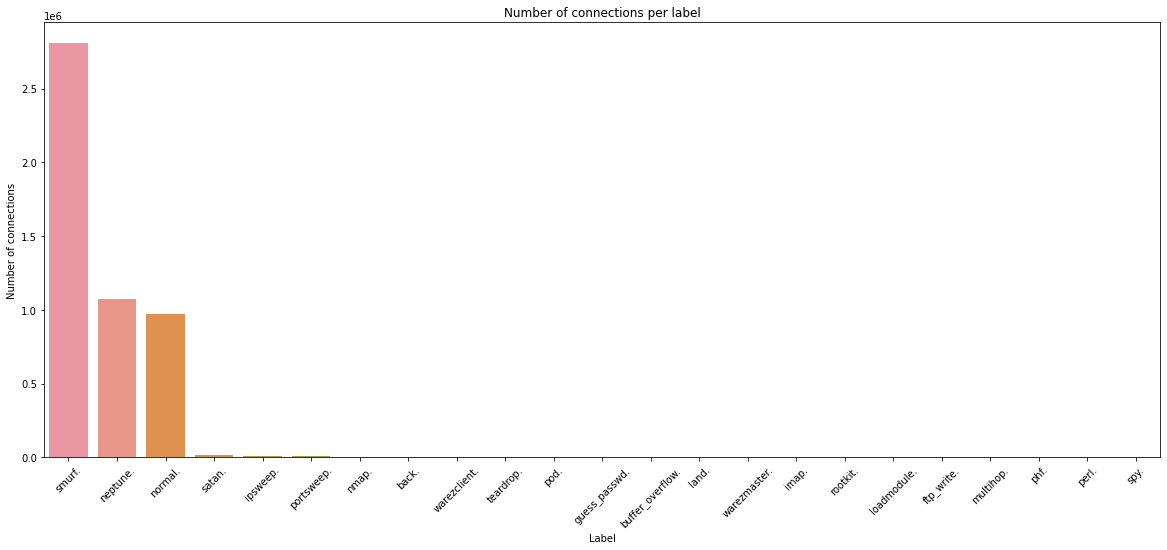

In [24]:
import seaborn as sns

y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [25]:
print("amount of connections of the first 3 labels:\t", y[0][1]+y[1][1]+y[2][1])


amount of connections of the first 3 labels:	 4852684


# **Question 2**
Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

You can use the following parameters:

* maxIterations=10
* runs=10
* initializationMode="random"
Discuss the result from your figure.

In [26]:
from pyspark.mllib.clustering import KMeans, KMeansModel

clusters = KMeans.train(data, 2, maxIterations=10,  initializationMode="random")


In [27]:
from operator import add

__ = labelsAndData.map(lambda x : (clusters.predict(x[1]), 1)).reduceByKey(add).collect()
for _ in __:
    print("Cluster %5d\tNumber of elements: %10d" %(_[0], _[1]))

Cluster     0	Number of elements:    4898431


In [28]:
sampled = data.sample(withReplacement=False, fraction=0.01)
datax = sampled.map(lambda x: x[0]).collect()
datay = sampled.map(lambda x: x[1]).collect()
dataz = sampled.map(lambda x: x[2]).collect()
labels_ = sampled.map(lambda x: clusters.predict(x)).collect()

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

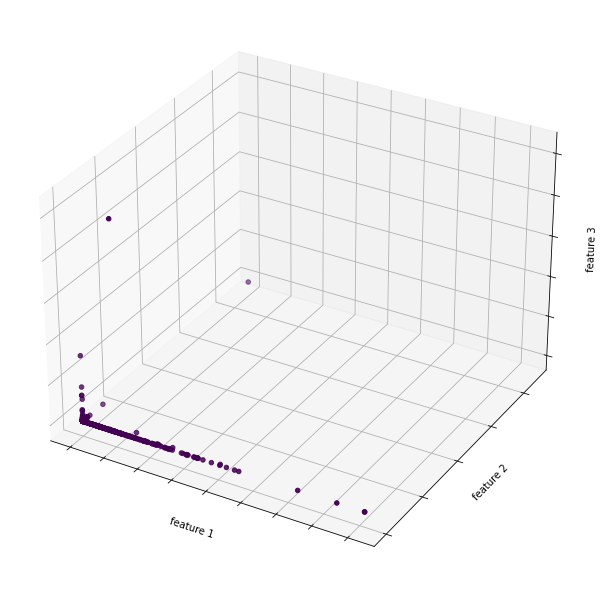

In [30]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax, datay, dataz, c=labels_)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

Above are the plots of the Principal Component Analysis did with k=3 and k=2.

First of all, what is PCA? It is a procedure to transform a set of variables, possibly correlated, into another set of uncorrelated variables called principal components. The number of principal components is less or equal to the number of initial variables and this technique is really useful when we want to reduce dimensionality. If we start for example with 38 dimensions, after the transformation we get a set of principal components and, according to the number of dimensions we want, we get the first k principal components. And why do we get the first and not random ones? Because the transformation is defined in such a way that the principal components are ordered with respect to how much variability of the data they account for.

Looking at the first plot, the one where we used 3 principal components, we can see that the majority of the data is packed up at the intersection of the 3 axis and that the data lies especially on the z-axis. This means that, even though we used 3 principal components, 2 of them don't have really high variance and in fact they don't show too much data.

The same happens for the second plot where we use just two components, and the data is still packed together in $(0,0)$ (in the next plots we'll try to zoom in).

But why all the data is perpendicular to each other?
Because, looking at the plot of the data (not with PCA), we can see that the points are already almost all perpendicular to each other and so, given that the eigenvalues are uncorrelated (and so orthogonal to each other), when multiplied with the points themselves, they get projected on just one of the axis every time.

We used the PCA function in the MLLib library otherwise it would have been impossibile to compute it in the full dataset.
Actually, when we initially tried to use PCA on a small sample of data and we managed to use the PCA function in the sklearn library, we had the possibility to understand the amount of variance with the explained_variance_ratio function and we discovered that with just two principal components, almost 100 percent of the information was represented.
This is a proof of what we saw before analyzing the data: that since so much of the data is represented with just 3 labels, it will be all packed together.

Looking closer at the second plot, we see that the dimensions are huge and so let's try to zoom into $(0,0)$.


In [31]:

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import PCA as PCAmllib

vectorData = data.map(Vectors.dense)
PCAModel3 = PCAmllib(3).fit(vectorData)
pcaData3 = PCAModel3.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

PCAModel2 = PCAmllib(2).fit(vectorData)
pcaData2 = PCAModel2.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

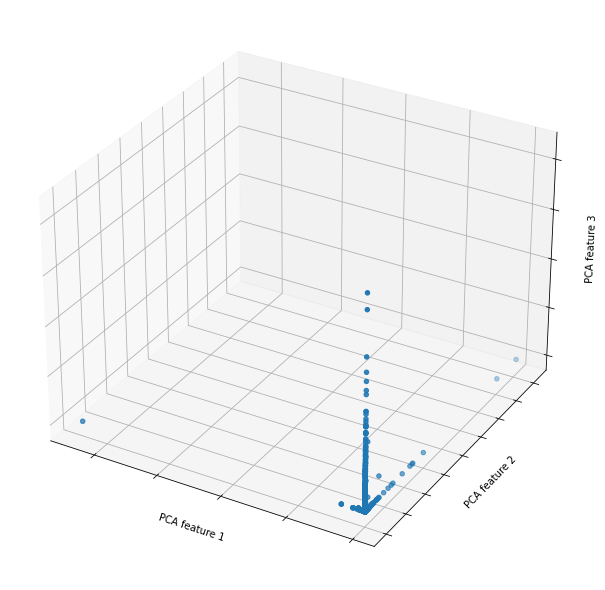

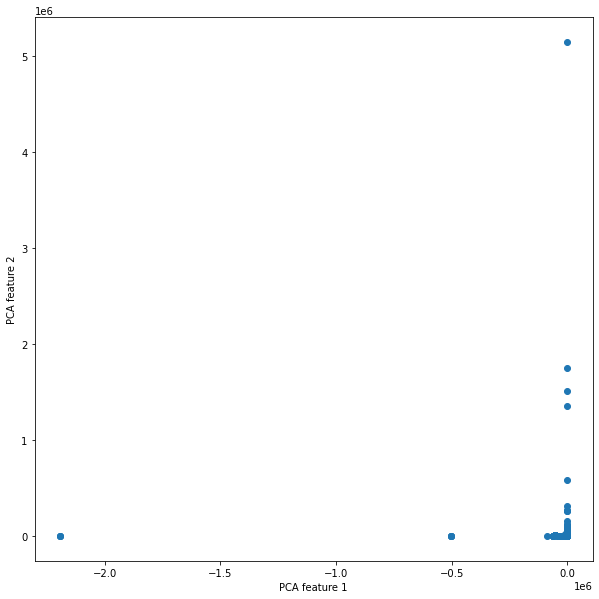

In [32]:
#pca plot
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig)

ax.scatter([x[0] for x in pcaData3], [x[1] for x in pcaData3], [x[2] for x in pcaData3])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')
plt.show()

fig = plt.figure(1, figsize=(10, 10))

plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

plt.show()

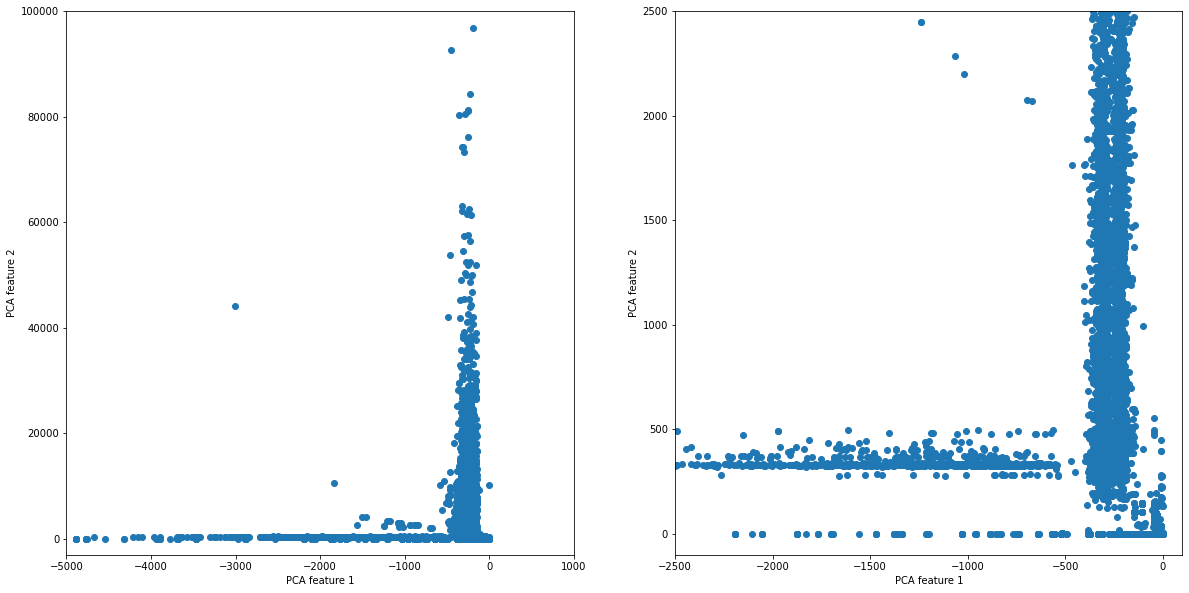

In [33]:
fig = plt.figure(1, figsize=(20, 10))
plt.subplot(121)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-5000,1000)
plt.ylim(-3000, 100000)

plt.subplot(122)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-2500,100)
plt.ylim(-100, 2500)
plt.show()

## This plot shows better the effectiveness of the PCA. All of the data is compressed in the previous plot because there are some points with a much higher value in those dimensions that make all the data shrink together. Zooming in, we can see that the majority of the points span in a small contour of the dimensions.


In [34]:

from pyspark.ml.feature import PCA as PCAml
from pyspark.sql import SQLContext
from pyspark.ml.linalg import Vectors
sqlContext = SQLContext(sc)
 
def make_it_work(array): #dummy function because Vectors.dense(array) would arise errors.
    return (Vectors.dense(array),)
 
vectorData = data.map(make_it_work)
df = sqlContext.createDataFrame(vectorData,["features"]) #for the pca with this library we have to use a dataframe
pca = PCAml(k=3, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
model.explainedVariance

DenseVector([0.6805, 0.3195, 0.0])

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center. 
We will now use a version of euclidean_distance that assumes the arguments to be numpy arrays, which is really faster, it will come to be useful because this function will be use several million times.

In [35]:
def euclidean_distance(a, b):
    c = a - b
    return np.sqrt(c.T.dot(c))

In [36]:
import time
from operator import add
t1 = time.time()
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point)**2

WSSSE = data.map(lambda point: error(clusters, point)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))
print(time.time() - t1)

Within Set Sum of Squared Error = 6.379392046833959e+18
23.445281744003296


# **Question 3**
This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Use the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs. What do you think about the result ?

In [37]:
clusterLabelCount = labelsAndData.map(lambda row: ((clusters.predict(row[1]), row[0]), 1)).reduceByKey(add)

for item in clusterLabelCount.collect():
    print(item)

((0, 'normal.'), 972781)
((0, 'neptune.'), 1072017)
((0, 'back.'), 2203)
((0, 'portsweep.'), 10413)
((0, 'warezclient.'), 1020)
((0, 'spy.'), 2)
((0, 'guess_passwd.'), 53)
((0, 'warezmaster.'), 20)
((0, 'satan.'), 15892)
((0, 'nmap.'), 2316)
((0, 'land.'), 21)
((0, 'multihop.'), 7)
((0, 'ipsweep.'), 12481)
((0, 'ftp_write.'), 8)
((0, 'buffer_overflow.'), 30)
((0, 'perl.'), 3)
((0, 'pod.'), 264)
((0, 'rootkit.'), 10)
((0, 'phf.'), 4)
((0, 'teardrop.'), 979)
((0, 'smurf.'), 2807886)
((0, 'imap.'), 12)
((0, 'loadmodule.'), 9)


In [38]:
nrLabelsPerCluster = labelsAndData.map(lambda x : (clusters.predict(x[1]), x[0])).groupByKey().collect()
for _ in nrLabelsPerCluster:
    print("Cluster %5d\tNumber of classes: %10d" %(_[0], len(np.unique(_[1].data))))

Cluster     0	Number of classes:         23


Your Comment

As we can see from this results, all of the data but 5 elements goes in one cluster while 5 elements labeled as portsweep go in the second cluster. (at least that was the result at the time of the comment but sometimes as we said before the result are different).
One cluster usually gets almost all the classes while the other one gets 1 or 0 classes (portsweep, more specifically).

The clusters are heavily unbalanced due to the disparity of the whole dataset and this tells us one important thing: that the majority of the point is stuck together and there is a really small amount of outliers (only 5 were recognized). There are surely more than 5 outliers but they hide for sure inside the first cluster.

The choice of k=2 could be better adapted; since there are 23 classes, it would make much more sense to use k=23 or more.

# **2.2.4. Choosing K**
How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of  k . For doing that, we have to build and evaluate models with different values of  k . A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

# **Question 4**
Use the function below to calculate the MSE of each model that is corresponding to each value of  k . Plot the results. From the obtained result, what is the best value for  k  ? Why ?

In [39]:
# k: the number of clusters
def clusteringScore(data, k, withCenters=False):
    clusters = KMeans.train(data, k, maxIterations=2, initializationMode="random")
    # calculate mean square error
    if withCenters is True:
        return (clusters.computeCost(data), len(clusters.centers))
    return clusters.computeCost(data)

In [40]:
k_vector = [2,5]

scores = [clusteringScore(data, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =   2, (effective nr. of clusters =   2) WSSSE = 6378634146314388480
k =   5, (effective nr. of clusters =   3) WSSSE = 6377867372571175936


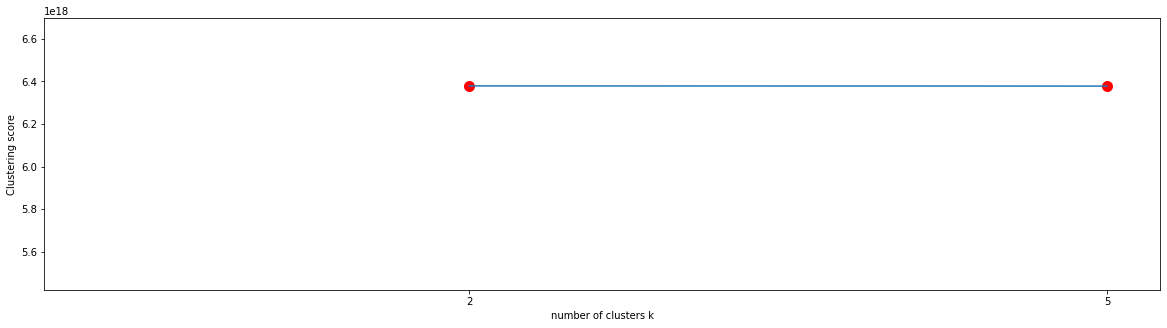

In [41]:

# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([0, np.max(k_vector)*1.05, 0.85*np.min(_), 1.05*np.max(_)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

Your comments

We tried a different increasing number of clusters and we plotted the results above.
As we can see from the plot and more importantly, as we know from the theory, increasing the number of clusters improves the clustering score. And this is quite obvious because if we put a huge number of clusters, for example the same as the number of points in the dataset, each point will be in its own cluster and the distance from the center will be zero. This is why simply increasing k to improve our clustering is not an efficient and sensible choice and we should find a compromise between number of clusters and clustering score.

The plot shows us that the initial choice of k=2 was absolutely nonsense being that the clustering score is really high with respect to the rest of the tests. Afterwards, with k=5, we have a huge drop when we test the KMeans. From k=23 onwards, the clustering score doesn't decrease anymore in a consistent way and so going further than 10/23 clusters doesn't seem to be a good choice.

This actually makes sense if we think about the data we are clustering: we have 23 different labels but actually many of them are pretty similiar and with similiar attributes and so when we use less clusters, they still stay packed together and increasing the clusters will just make more clusters really near to each other not improving the clustering score.

Other than simply looking at the plot, another more methodological solution could have been to apply the Minimum Description Length Principle that tries to find the best optimization for k. 

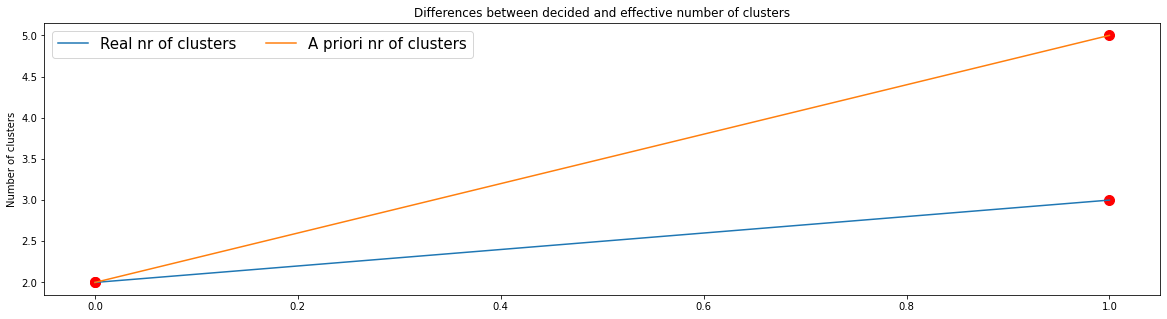

In [42]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

We tried to go further in details on the previous plot and, knowing from theory that increasing the number of clusters usually improves the error, we were wondering why the clusteringScore stayed the same after a certain point.

In the plot above, we decided to plot the number of clusters per run, k, together with the effective number of clusters. What do we mean with effective number of clusters? When the kmeans algorithm runs, the various points change cluster as the centers get updated. If, after reassigning the points, one of the cluster becomes empty, it is deleted from the list of clusters.

As we can see from the plot above, when the number of clusters is small, none of them is deleted but, as we increase the number of clusters, the effective number of clusters doesn't increase with the same pace and this is why the clusteringScore doesn't improve a lot. The trend is that after 20 clusters, approximately half of the desired clusters gets deleted. We can see this from the slope and also from the detailed numbers in the printing above that:
30 drops to 11
50 -> 26
70 -> 38
100 -> 48
120 -> 60
...
400 -> 190

# **2.2.5 Normalizing features**
K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias.

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation
\begin{align}
normalize_i=\frac{feature_i - \mu_i}{\sigma_i}
\end{align}
Where,
* $normalize_i$  is the normalized value of feature $i$ 
* $\mu_i$ is the mean of feature $i$ 
* $\sigma_i$ is the standard deviation of feature $i$

# **Question 5**
Complete the code below to normalize the data. Print the first 5 lines of the new data.

HINT: If $\sigma_i=0$ then ${normalize}_i = {feature}_i−\mu_i$

In [43]:
def normalizeData(labelsAndData):
     # calculate means
    means = labelsAndData.map(lambda x:x[1]).mean()
    # calculate standard deviation of each feature
    stdevs = np.sqrt(labelsAndData.map(lambda x : (x[1]-means)**2).mean())
    
    stdevs[stdevs==0] = 1
    def normalize(point):
        return (point[0],(point[1]-means)/stdevs)

    return labelsAndData.map(lambda x: normalize(x))

labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x: x[1]).cache()
print(normalizedData.take(5))

[array([-6.68331854e-02, -1.72038228e-03,  6.81884351e-02, -2.39084686e-03,
       -1.51391734e-02, -1.10348462e-03, -2.65207600e-02, -4.39091558e-03,
        2.44279187e+00, -2.09732783e-03, -8.25770840e-03, -4.54646139e-03,
       -3.28458917e-03, -9.57233922e-03, -8.50457842e-03, -2.87561127e-02,
        0.00000000e+00, -6.38979005e-04, -2.89113034e-02, -1.57541507e+00,
       -1.19624324e+00, -4.66042614e-01, -4.65755574e-01, -2.48285775e-01,
       -2.48130352e-01,  5.39733093e-01, -2.56056520e-01, -2.01059296e-01,
       -3.63913926e+00, -1.78651044e+00, -1.83302273e+00, -2.82939000e-01,
       -1.25793664e+00, -1.56668488e-01, -4.66404784e-01, -4.65453641e-01,
       -2.50831829e-01, -2.49631966e-01]), array([-6.68331854e-02, -1.77667956e-03,  5.32451452e-03, -2.39084686e-03,
       -1.51391734e-02, -1.10348462e-03, -2.65207600e-02, -4.39091558e-03,
        2.44279187e+00, -2.09732783e-03, -8.25770840e-03, -4.54646139e-03,
       -3.28458917e-03, -9.57233922e-03, -8.50457842e-03

# **Question 6**
Using the new data, build different models with different values of $k\in [60,70,80,90,100,110]$ . Evaluate the results by plotting them and choose the best value of $k$.

In [44]:
k_vector = [60,70,80,90,100,110]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  60, (effective nr. of clusters =  30) WSSSE = 88233442
k =  70, (effective nr. of clusters =  42) WSSSE = 81645085
k =  80, (effective nr. of clusters =  43) WSSSE = 69820447
k =  90, (effective nr. of clusters =  53) WSSSE = 71622123
k = 100, (effective nr. of clusters =  55) WSSSE = 76107363
k = 110, (effective nr. of clusters =  50) WSSSE = 77108483


Your comments

# **Question 7**
Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

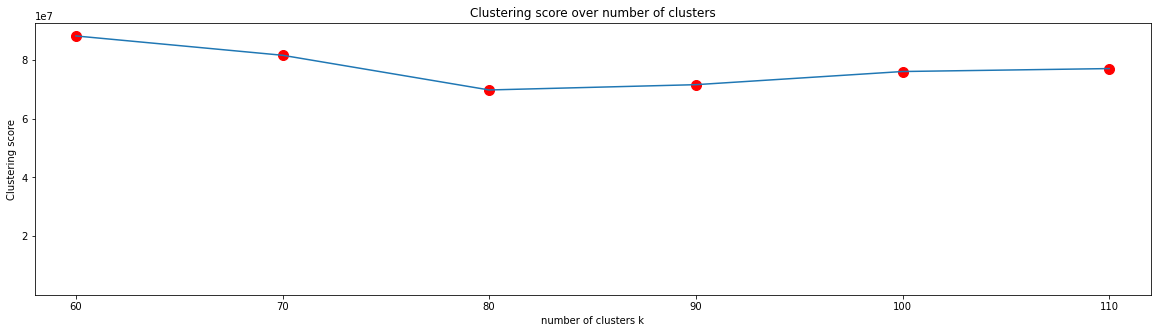

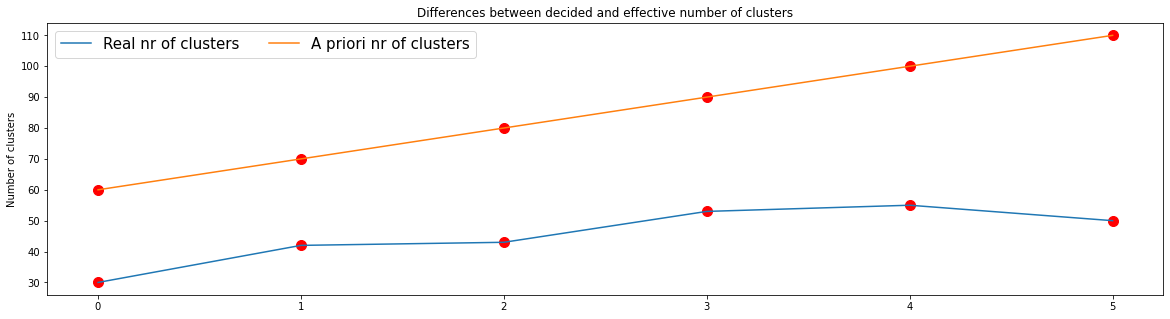

In [45]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([58,112, 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()


First of all, before commenting the plot, we notice one important fact:
The scale for the WSSSE dropped consistently from a magnitude of $10^{18}$ to a magnitude of $10^{7}$

Other than this, we can still see the trend that increasing the number of clusters reduces the clustering score although here is much less visible since the number of clusters is really high.

Also, plotting the real and the expected number of clusters, we can see that the trend is always similiar and that the effective clusters are always much smaller (almost half) of the expected ones.

In [47]:
#let's use k as the best in the previous question = 80
clusters = KMeans.train(normalizedData, k=80, maxIterations=10,  initializationMode="random")

#get three axis on the first three attributes
sampledNormalized = normalizedData.sample(withReplacement=False, fraction=0.01)
datax_norm = sampledNormalized.map(lambda x: x[0]).collect()
datay_norm = sampledNormalized.map(lambda x: x[1]).collect()
dataz_norm = sampledNormalized.map(lambda x: x[2]).collect()
labels_norm = sampledNormalized.map(lambda x: clusters.predict(x)).collect()

#let's do also pca to see the difference


Py4JJavaError: An error occurred while calling o974.fitPCA.
: java.lang.ClassCastException: org.apache.spark.ml.linalg.DenseVector cannot be cast to org.apache.spark.mllib.linalg.Vector
	at org.apache.spark.mllib.feature.PCA.fit(PCA.scala:44)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.fitPCA(PythonMLLibAPI.scala:654)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


Normalizing values allowed a more standard variance for the different attributes and we can see the improvements in both plots.

The first plot is done with the first three features and this is to show that even if we normalize the data, and so the values change, the relationship between different points remain the same in fact, if you have a look at the first plot in question 3, it didn't change at all (without considering the colors that are random for each class and that the data is sampled so some points may differ, but the distribution is mantained).

The second plot is more interesting and shows a sample of 1% of the data plotted on the first three principal components.

If we look side by side at this plot and at the PCA plot in question 3, we can see that thanks to data normalization, the data is spread more equally on the different principal components. We can see that the data is not packed together like it was before and so this may improve our anomaly detection thanks to a better division of clusters.

# **2.3. Clustering using categorical features**
# **2.3.1 Loading data**
In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering. The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in  d -dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice blog post on the problem.

There are two approaches:

* **Approach 1:** mapping one categorial feature to one numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* Approach 2: mapping mapping one categorial feature to multiple numerical features. Basically, a single variable with  n  observations and  d  distinct values, to  d  binary variables with  n  observations each. Each observation indicating the presence (1) or absence (0) of the  dth  binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes
\begin{align}
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
\end{align}
We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.

# **Question 8**
Calculate the number of distinct categorical features value (at index 1,2,3). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

In [48]:
feat1 = raw_data.map(lambda x : x.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda x : x.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda x : x.split(",")[3]).distinct().collect()

In [49]:
print("feature 1: length = %d\nfeatures = \n%s\n" %(len(feat1), feat1))
print("\nfeature 2: length = %d\nfeatures = \n%s\n" %(len(feat2), feat2))
print("\nfeature 3: length = %d\nfeatures = \n%s\n" %(len(feat3), feat3))

feature 1: length = 3
features = 
['tcp', 'udp', 'icmp']


feature 2: length = 70
features = 
['time', 'courier', 'red_i', 'pop_3', 'smtp', 'ftp', 'login', 'http_443', 'IRC', 'bgp', 'link', 'shell', 'gopher', 'Z39_50', 'csnet_ns', 'eco_i', 'efs', 'name', 'rje', 'systat', 'pm_dump', 'tim_i', 'urh_i', 'uucp', 'tftp_u', 'whois', 'domain', 'remote_job', 'discard', 'sunrpc', 'aol', 'finger', 'ntp_u', 'other', 'ldap', 'echo', 'kshell', 'ctf', 'X11', 'sql_net', 'iso_tsap', 'ssh', 'nntp', 'hostnames', 'telnet', 'urp_i', 'mtp', 'netbios_dgm', 'klogin', 'http_2784', 'supdup', 'imap4', 'netbios_ssn', 'nnsp', 'netstat', 'domain_u', 'auth', 'private', 'exec', 'uucp_path', 'netbios_ns', 'harvest', 'http', 'ecr_i', 'ftp_data', 'vmnet', 'daytime', 'printer', 'pop_2', 'http_8001']


feature 3: length = 11
features = 
['OTH', 'S3', 'SF', 'REJ', 'RSTO', 'RSTOS0', 'SH', 'S2', 'S0', 'S1', 'RSTR']



In [50]:
f1 = raw_data.map(lambda x : x.split(",")[1]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f2 = raw_data.map(lambda x : x.split(",")[2]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f3 = raw_data.map(lambda x : x.split(",")[3]).map(lambda x : (x, 1)).reduceByKey(add).collect()

f1.sort(key=lambda x : x[1], reverse=True)
f2.sort(key=lambda x : x[1], reverse=True)
f3.sort(key=lambda x : x[1], reverse=True)

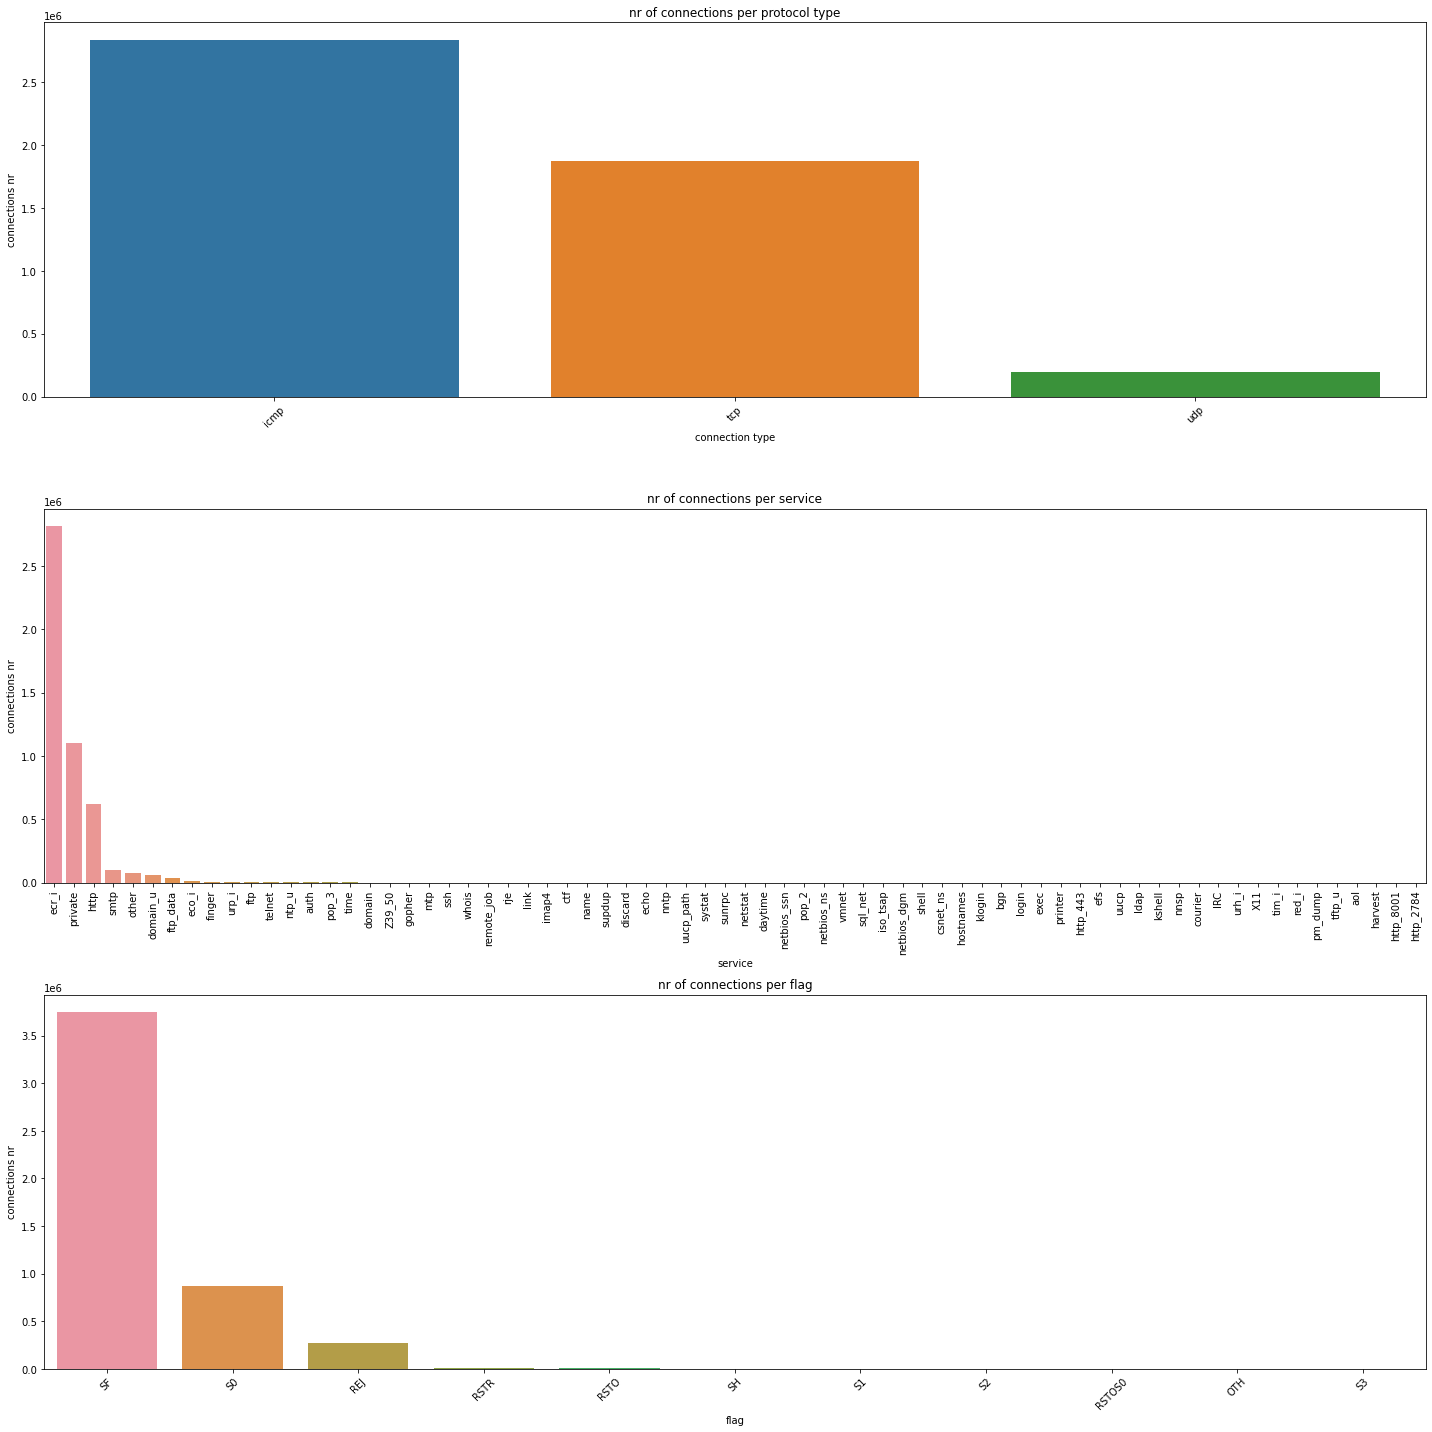

In [51]:
#plotting
a = plt.figure(figsize=(20,20))
plt.subplot(311)
sns.barplot(x=np.arange(len(f1)), y=[_[1] for _ in f1])
plt.xticks(np.arange(len(f1)), [_[0] for _ in f1], rotation=45)
plt.title("nr of connections per protocol type")
plt.xlabel("connection type")
plt.ylabel("connections nr")

plt.subplot(312)
sns.barplot(x=np.arange(len(f2)), y=[_[1] for _ in f2])
plt.xticks(np.arange(len(f2)), [_[0] for _ in f2], rotation="vertical")
plt.title("nr of connections per service")
plt.xlabel("service")
plt.ylabel("connections nr")

plt.subplot(313)
sns.barplot(x=np.arange(len(f3)), y=[_[1] for _ in f3])
plt.xticks(np.arange(len(f3)), [_[0] for _ in f3], rotation=45)
plt.title("nr of connections per flag")
plt.xlabel("flag")
plt.ylabel("connections nr")

plt.tight_layout()

plt.show()

In [53]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*len(feat1)
    featureOfCol1[feat1.index(vector[1])] = 1
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0]*len(feat2)
    featureOfCol2[feat2.index(vector[2])] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0]*len(feat3)
    featureOfCol3[feat3.index(vector[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
#data = labelsAndData.values().cache()

#with our normalizeData function, we can simply do:
labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x:x[1]).cache()

# **2.3.2. Building models**
# **Question 9**
Using the new data, cluster the connections with different values of $k\in [80,90,100,110,120,130,140,150,160]$. Evaluate the results and choose the best value of  k  as previous questions.

In [54]:
k_vector = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

Py4JJavaError: An error occurred while calling o1296.computeCostKmeansModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 13 in stage 171.0 failed 1 times, most recent failure: Lost task 13.0 in stage 171.0 (TID 3546) (LAPTBLR134.octasic.com executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.DoubleRDDFunctions.$anonfun$sum$1(DoubleRDDFunctions.scala:35)
	at scala.runtime.java8.JFunction0$mcD$sp.apply(JFunction0$mcD$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.DoubleRDDFunctions.sum(DoubleRDDFunctions.scala:35)
	at org.apache.spark.mllib.clustering.KMeansModel.computeCost(KMeansModel.scala:113)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.computeCostKmeansModel(PythonMLLibAPI.scala:378)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 20 more


In [ ]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([18, 1.05*np.max(k_vector), 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
plt.xlim([-0.05, np.max(len(k_vector))])
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()



Your comments



# **2.4. Anomaly detection**
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

# **Question 10**
Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

HINT: The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [ ]:
#Your code

Your comments